In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = 'habits/'
answers_file = "questionnaire_answers.csv"
questions_file = 'questions_table.csv'
subquestionnaire_file ="questionnaire-subhabit_table.csv"
questionnaire_file = "questionnaire_table.csv"

# load the data
questionnaire_answers= pd.read_csv(DATA_FOLDER + answers_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire_questions= pd.read_csv(DATA_FOLDER + questions_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()
questionnaire = pd.read_csv(DATA_FOLDER + questionnaire_file, sep=',', skiprows = 1, error_bad_lines=False, encoding = "utf-8").dropna()
subquestionnaire= pd.read_csv(DATA_FOLDER + subquestionnaire_file, sep=',', error_bad_lines=False, encoding = "utf-8").dropna()

In [52]:
def get_corr(q_id, subquest, quest, answers, questions):
    is_sub = False
    nb_q_per_q = questionnaire_questions.groupby(['questionnaire identifier']).size().reset_index().rename(columns={0:'records'})
    # list of questionnaire that are composed of subquestionnaires
    is_split = list(subquest['reference habit identifier'])
    #list of subquestionnaires
    is_subq = list(subquest['subhabit identifier'])
    if (q_id in is_subq):
        is_sub = True
    list_q = []
    if (q_id in is_split):
        list_q = list(subquest.loc[subquest['reference habit identifier'] == q_id]['subhabit identifier'])
    else:
        list_q.append(q_id)
    nb_quest = 0
    frames = []
    for l in list_q:
        q_tmp = answers.loc[answers['questionnaire identifier'] == l]
        frames.append(q_tmp)
        nb_quest += int(nb_q_per_q.loc[nb_q_per_q['questionnaire identifier'] == l]['records'])
    
    # contains the answers for a given questionnaire
    q = pd.concat(frames)
    
    # get the list of ids of the users keeping only those that completed the entire questionnaire
    users = q.groupby(['user identifier']).size().reset_index().rename(columns={0:'records'})
    users = users.loc[users['records'] == nb_quest]
    
    frames = []
    i=0
    for u in users['user identifier']:
        u_tmp = q.loc[q['user identifier'] == u][['question identifier', 'score of the answer']].reset_index()[['score of the answer']].T
        frames.append(u_tmp)
        q_table = q.loc[q['user identifier'] == u][['question identifier']]

    # contains the answer for a given questionnaire sorted by user (1 line = 1 user; 1 row = 1 question)
    questions_table = pd.concat(frames)
    
    frames = []
    for r in q_table['question identifier']:
        r_tmp = questions.loc[questions['question identifier'] == r][['text', 'questionnaire identifier']]
        frames.append(r_tmp)
    questions_text = pd.concat(frames).reset_index()
    
    corr = questions_table.corr()
    title = ""
    if (is_sub):
        title = subquest.loc[subquest['subhabit identifier'] == q_id]['subhabit title'].iloc[0]    
    else:
        title = quest.loc[quest['questionnaire identifier'] == q_id]['questionnaire title'].iloc[0]
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True).set_title(title)
    plt.show()
    return questions_table, questions_text


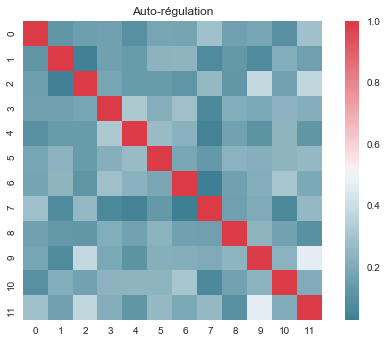

,0,1,2,3,4,5,6,7,8,9,10,11
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,4.870317,2.602305,6.023055,3.942363,4.668588,4.377522,4.319885,4.899135,4.694524,5.599424,4.365994,5.190202
std,1.595844,1.561012,1.150290,1.697369,1.791831,1.680855,1.679090,1.649549,1.637370,1.206102,1.681692,1.449982
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,1.000000,6.000000,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,5.000000,3.000000,4.000000
50%,5.000000,2.000000,6.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,5.000000
75%,6.000000,3.000000,7.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [57]:
qt, qtt = get_corr(1, subquestionnaire, questionnaire, questionnaire_answers, questionnaire_questions)
qt.describe()

In [58]:
qtt

,index,text,questionnaire identifier
0,0,"En classe, je manque souvent des points import...",1
1,1,"Lorsque je lis un document pour ce cours, je p...",1
2,2,Lorsque je lis un document pour ce cours et qu...,1
3,3,Si les documents du cours sont difficiles à co...,1
4,4,Avant d’étudier un nouveau document du cours e...,1
5,5,Je me pose des questions à moi-même pour être ...,1
6,6,J’essaie de changer la façon dont j’étudie pou...,1
7,7,Je constate souvent que même si j’ai relu les ...,1
8,8,"Lorsque j’étudie pour ce cours, j’essaie d’ana...",1
9,9,"Lorsque j’étudie pour ce cours, j’essaie d’ide...",1


1


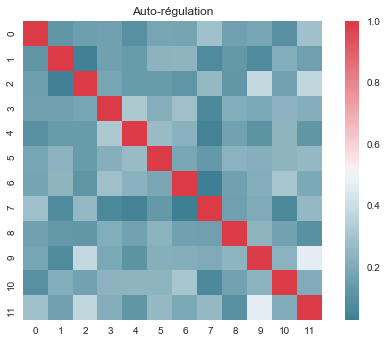

2


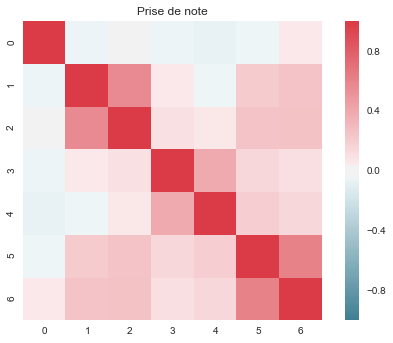

3


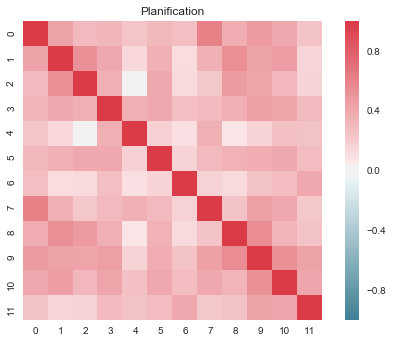

4


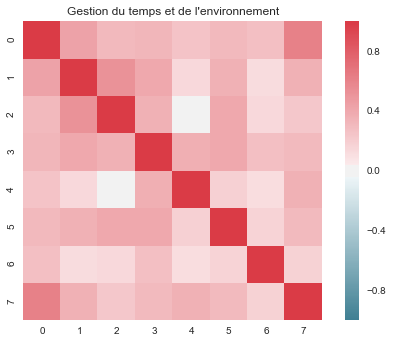

5


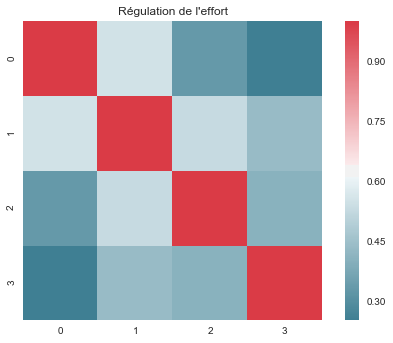

6


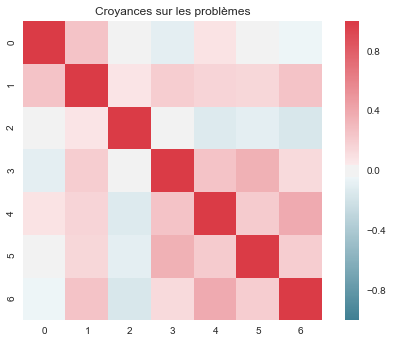

7


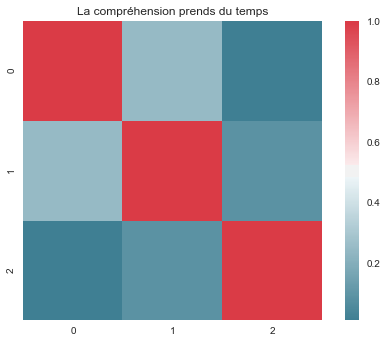

8


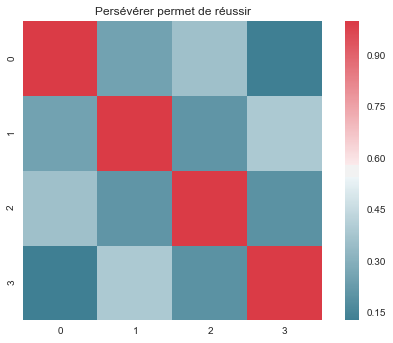

9


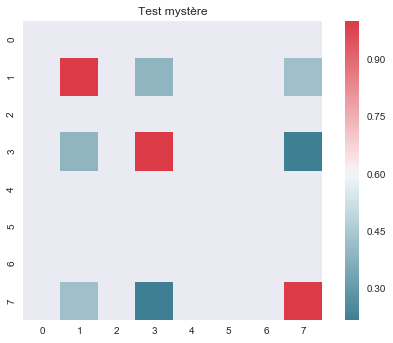

10


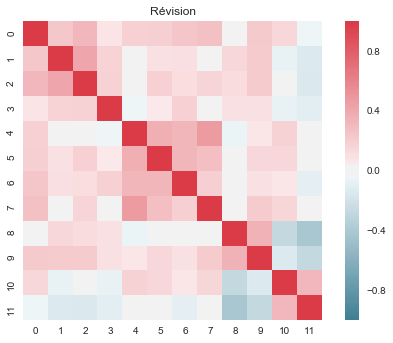

11


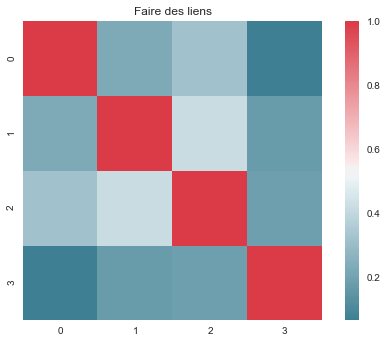

12


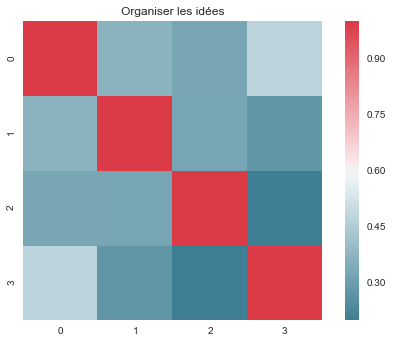

13


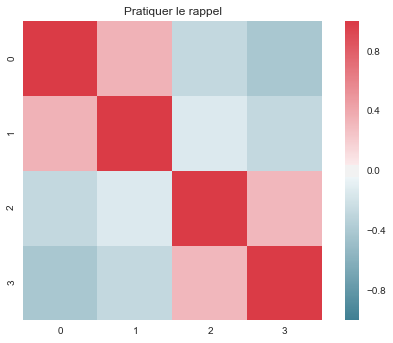

14


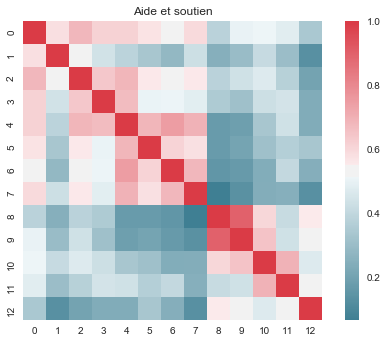

15


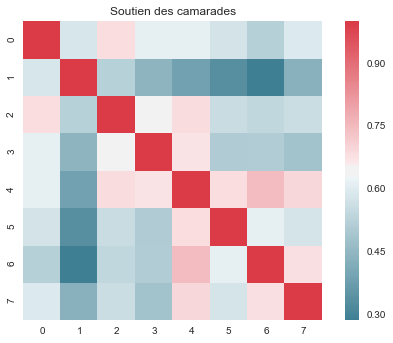

16


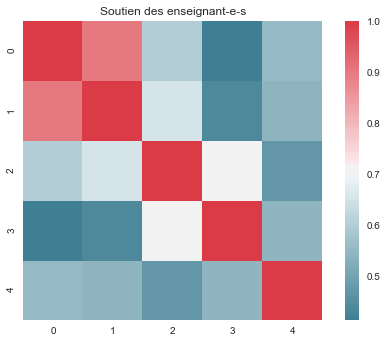

17


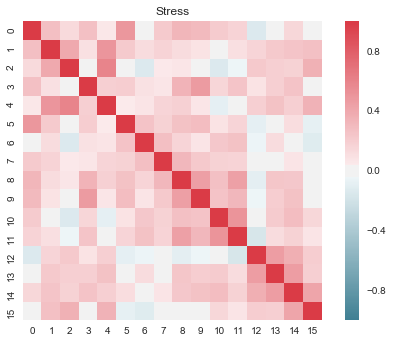

18


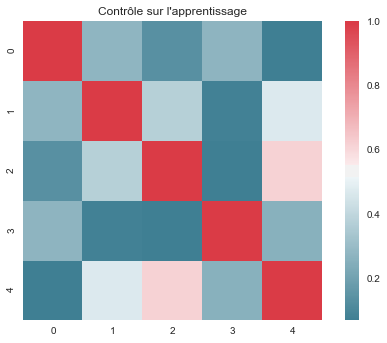

19


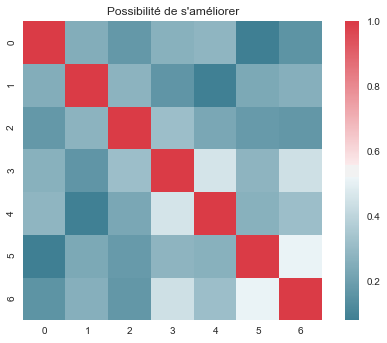

20


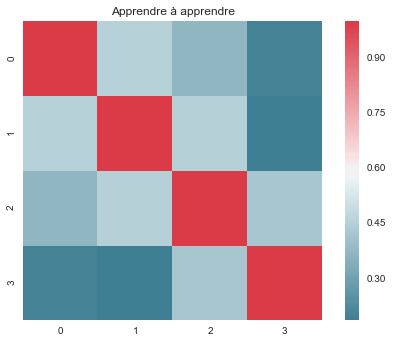

21


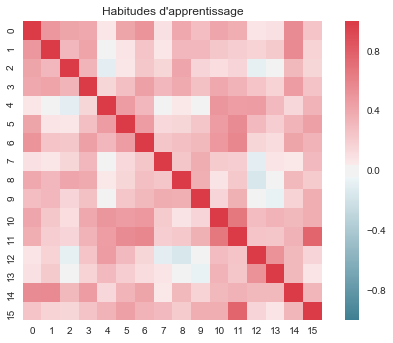

22


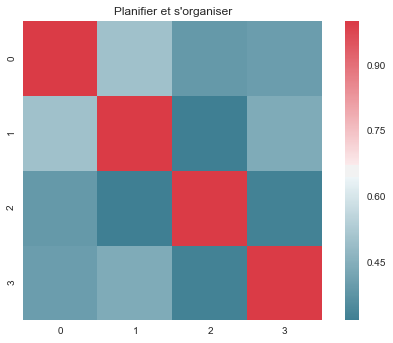

23


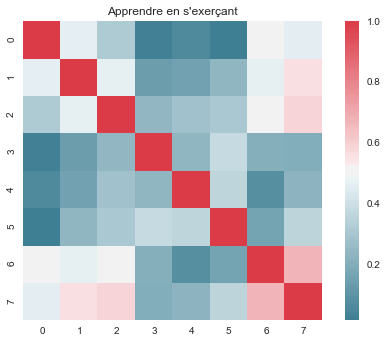

24


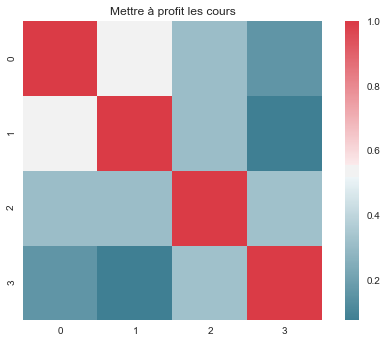

25


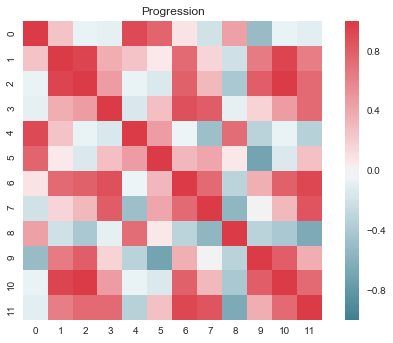

In [4]:
for i in range(1,26):
    print(i)
    get_corr(i, subquestionnaire, questionnaire, questionnaire_answers)